# Interpreting implicit feedback data for expert systems



Plan: 


0.5) Clean code of rank monitor (Work-ahead for the logging of next sprint)

1) Accurately Interpreting Clickthrough Data as Implicit Feedback (SIGIR 2016 Test Of Time Award)
	

	Trust bias   - > Bias to 'trust' engine click first reult
	Quality Bias - > If the relevance of the retrieved results decreases, 
			 users click on abstracts that are on average
		         less relevant

	Example set = S1 = {l1,. .. l7}
	
	S1 =    l1* l2 l3* l4 l5* l6 l7

	5 Strategies. 
	Click > Skip Above, 
	Last Click > Skip Above, 
	Click > Earlier Click, 
	Click > Skip Previous, 
	Click > No Click Next

2) Relative rankings to gold-set list
	2.1 Take set from SearchText that have been queried for ~200 or more times.
	2.2 Implement methodology from above paper.
	2.3 Implement graph methodology from other paper that builds on 1. 
		2.3.1 Construct graph of relevance paths. 
		2.3.2 Find largest connected graph. 

3) Delphi Questionnaires
	Does this approach match with what Delphi Questionaire would give us. 



</b>



To get a faceted search:

# Facet Search: 

http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Logging_Slave/select?facet.field=SearchText&facet.mincount=200&facet=on&indent=on&q=EventID:164%20UserID:*&rows=0&wt=jsonueyr

De query: "unieke test query"
Aangeklikt: [3, 5, 7 17]  ->  (18-06-2019)
Aangeklikt: [1,10]        ->  (18-06-2019) +5 min later
Aangeklikt: [1,3,7]       ->  (18-06-2019) +25 min later

De Query: "test information retrieval"
Aangeklikt: [2, 5, 8, 26] ->  (18-06-2019)
Aangeklikt: [4, 12]       ->  (18-06-2019) + 5 min later
Aangeklikt: [1, 2, 5]     ->  (18-06-2019) +25 min later


In [1]:
import numpy as np
from sklearn.metrics import f1_score, average_precision_score
import math
import requests
import os
import itertools

from urllib import *
import json

from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from collections import Counter
from tqdm import tqdm_notebook 
tqdm_notebook().pandas()
from tqdm import tqdm_notebook as tqdm

from time import strftime, gmtime
import datetime
from datetimerange import DateTimeRange
from datetime import timedelta  
from  dateutil import parser


# Greedy IDE completion 
%config IPCompleter.greedy=True

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; } </style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 25)



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Graph-building packages
import community
import networkx as nx
import matplotlib.pyplot as plt

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

# Request dataframe from solr

In [2]:
def request_into_dataframe(rows= 100, query= '*:*', sort=''):
    """
    :param rows: amount of rows to request
    :param query: string to query
    :param sort: string to sort the request eg. sort='ShortTimeStamp desc'
    """
    
    url = 'http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr' \
    '/ACC_Logging_Slave/select?indent=on&q={}&rows={}&sort={}&start=0&wt=json'.format(query,rows,sort)

    response = requests.get(url)
    
    # Transform the request into a json
    response = response.json()

    response = response['response']['docs']

    df =  pd.DataFrame(response)
     
    return df
    

In [4]:
def get_27_frame(query: str) -> pd.DataFrame:
    """
    Get all the logging with a clicked documentPosition. 
    :param query: query string
    :return:
    """
    
    df_27_bitcoin = request_into_dataframe(rows=1000000000, query='EventID:27 AND DocumentPosition:*')

    df_27_bitcoin.to_hdf('./multiple_query/df27_{}'.format(query), key='test', mode='w')

    return df_27_bitcoin


def get_16_frame(query:  str) -> pd.DataFrame:
    """
    Get every search log from people with a UserID:* 
    :param query: query string
    :return: 
    """
    
    df_164_bitcoin = request_into_dataframe(query='EventID:164 AND SearchText:"{}" AND UserID:*'.format(query)
                                          , rows = 1000000000)
    
    # Keep only filterpath is NaN so only searches regular engine. 
    df_164_bitcoin = df_164_bitcoin[pd.isna(df_164_bitcoin['FilterPath'])]
    
    # Inster an empty column with to be filled document positions 
    df_164_bitcoin['DocumentPosition'] = df_164_bitcoin.progress_apply(lambda x: [], axis=1)
    
    df_164_bitcoin.to_hdf('./multiple_query/df164_{}'.format(query), key='test', mode='w')

    return df_164_bitcoin



In [5]:
currentdir = Path('./data/')
[file for file in currentdir.glob('*')]
[file for file in Path('./').glob('*')]

df_164_bitcoin = pd.read_hdf('df164_bitcoin')
df_27_bitcoin  = pd.read_hdf('df27_bitcoin')
df_164_bitcoin = df_164_bitcoin[pd.isna(df_164_bitcoin['FilterPath'])]

df_164_bitcoin

df_27_bitcoin

[PosixPath('data/EventID:164 AND Year:2019 AND UserID:*.hdf'),
 PosixPath('data/EventID:164 AND Year:2016 AND UserID:* AND SearchText:*.hdf'),
 PosixPath('data/EventID:164 AND Year:2018 AND UserID:*.hdf'),
 PosixPath('data/aggregated_processed.h5'),
 PosixPath('data/EventID:27Full2019.hdf'),
 PosixPath('data/test.edges'),
 PosixPath('data/EventID:27Full2018.hdf'),
 PosixPath('data/EventID:164 AND Year:2017 AND UserID:*.hdf'),
 PosixPath('data/EventID:164Full2019.hdf')]

[PosixPath('rank_monitor.ipynb'),
 PosixPath('data'),
 PosixPath('Large-graph.png'),
 PosixPath('queries_multiple_times.ipynb'),
 PosixPath('df164_bitcoin'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('Plan_next_weeks.txt'),
 PosixPath('graphbuilder.ipynb'),
 PosixPath('text_files'),
 PosixPath('df27_bitcoin'),
 PosixPath('test_matrix.ipynb'),
 PosixPath('nos_scrape'),
 PosixPath('Pairwise.png'),
 PosixPath('old'),
 PosixPath('Interpretingwithfancymarkdown.ipynb'),
 PosixPath('17:0017april.ipynb'),
 PosixPath('multiple_query'),
 PosixPath('Untitled1.ipynb'),
 PosixPath('Untitled.ipynb')]

,AppID,CompID,EventID,FilterPath,ID,Month,Quarter,SearchText,SearchTypeID,ShortTimeStamp,SiteID,TimeStamp,TotalResult,UserID,Week,Year,_version_,DocumentPosition
0,1,349,164,NaN,b1b04a29-3fec-4471-a355-878d06aa1cf9,4,2,bitcoin,1,20190416,1,2019-04-16T21:36:24.319Z,1307,101109,16,2019,1631008184459067392,[]
1,1,341,164,NaN,08b2c42c-9773-44b4-aa83-2d3bae15bff2,4,2,bitcoin,1,20190414,1,2019-04-14T14:55:05.874Z,1267,165652,15,2019,1630801728132612096,[]
2,1,341,164,NaN,d979f2f6-b012-42ed-a0ff-8a72c78c4121,4,2,bitcoin,1,20190414,1,2019-04-14T14:32:02.042Z,1267,165652,15,2019,1630800265559932928,[]
4,1,349,164,NaN,b274506e-7332-4864-ad45-28e551ca305e,5,2,bitcoin,1,20190510,1,2019-05-10T11:12:12.454Z,1230,98226,19,2019,1633143209257336832,[]
5,1,349,164,NaN,c0104040-ac9d-48d6-aa44-32df3f6f9fe0,5,2,bitcoin,1,20190510,1,2019-05-10T11:08:43.781Z,1230,98226,19,2019,1633143025068670976,[]
12,1,349,164,NaN,68c4a66c-9096-4914-b5c6-637b5b053179,4,2,bitcoin,1,20190423,1,2019-04-23T11:12:07.515Z,1230,98226,17,2019,1631603053922615296,[]
15,1,379,164,NaN,3cb4e9f5-40c8-47a6-8277-c6a85c9dda02,4,2,bitcoin,1,20190430,1,2019-04-30T07:08:45.487Z,1123,127765,18,2019,1632221922315993088,[]
16,1,379,164,NaN,71109025-39ec-49a5-bdcb-c8e47ed0151b,4,2,bitcoin,1,20190430,1,2019-04-30T07:09:00.590Z,1123,127765,18,2019,1632221938148442112,[]
17,1,349,164,NaN,2c14f33d-0f01-40e8-a4fb-7179a4f61c88,5,2,bitcoin,1,20190514,1,2019-05-14T09:51:05.842Z,1232,98226,20,2019,1633500492725223424,[]
22,1,379,164,NaN,5656971f-99c6-440e-9cbd-7f09e16af686,5,2,bitcoin,1,20190512,1,2019-05-12T12:49:50.213Z,1115,127765,19,2019,1633330605385056256,[]


,AppID,CompID,Department,DocumentID,DocumentPosition,DocumentSource,DocumentURL,EventID,FunctionArea,ID,Month,Publisher,Quarter,RunID,SearchText,SearchTypeID,ShortTimeStamp,SiteID,TimeStamp,UserID,Week,Year,_version_
0,1,680,NaN,31832265,3,Rechtspraak.nl,http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,NaN,9ec733c2-4f59-4cd5-81db-d8b7e38539d5,4,Diversen,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:30.431Z,226603,16,2019,1630888681683288064
1,1,2058,Dispute resolution,8747387,1,Privaatrechtelijke Aspecten van Onroerend Goed,https://www.navigator.nl/#/document/idb10654e4...,27,NaN,e677e538-8e78-4c60-9cf1-574107cb5177,4,Kluwer,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:35.947Z,226667,16,2019,1630888681745154048
2,1,154,NaN,3911885,2,Commentaar Ondernemingsrecht,http://www.legalintelligence.com/documents/loc...,27,NaN,f9eeb8bd-63ab-4ad9-8d8a-aa4788793c9f,4,SDU,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:40.841Z,21170,16,2019,1630888681792339968
3,1,1062,Ondernemingsrecht,30343216,9,ACM,https://www.acm.nl/sites/default/files/old_pub...,27,Juridisch medewerker,a7b3b340-cad9-4372-8957-9a41ec832058,4,Diversen,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:46.527Z,224219,16,2019,1630888681825894400
4,1,396,NaN,14165432,35,BB,https://www.navigator.nl/#/document/id4037f502...,27,Advocaat-Stagiair,4b2832ea-8bc3-405a-a342-4699a701202b,4,Kluwer,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:49.643Z,188992,16,2019,1630888681857351680
5,1,1220,Team Strafrecht 3,197606,36,Rechtspraak.nl,http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,NaN,114a4e06-6192-46b7-a5cb-75fc7a10516d,4,Diversen,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:50.268Z,78842,16,2019,1630888681880420352
6,1,841,NaN,22493369,12,NTB,https://www.navigator.nl/#/document/id9454d943...,27,NaN,7fa46e77-ca05-4a1b-8437-944a2428e14a,4,Kluwer,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:51.418Z,195892,16,2019,1630888681943334912
7,1,680,NaN,30847090,4,USZ,http://www.legalintelligence.com/documents/loc...,27,NaN,f44b13bf-7595-42c0-9681-c9ca47c13d31,4,SDU,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:52.448Z,229605,16,2019,1630888681982132224
8,1,1220,Civiel,27699904,5,JOR,http://www.legalintelligence.com/documents/loc...,27,NaN,35113496-7615-40ac-bcca-ea3ea32d7c75,4,SDU,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:53.366Z,79295,16,2019,1630888682013589504
9,1,457,NaN,25136076,1,GST,https://www.navigator.nl/#/document/idcac860a1...,27,NaN,ddb49b2c-aceb-4477-92e1-dfdd2701224a,4,Kluwer,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:58Z,135693,16,2019,1630888682081746944


In [6]:
def check_in_timerange(timestamp : datetime.datetime, query = pd.DataFrame, df_27 = pd.DataFrame) -> list:
    """
    Check if the there are clickedobjects within + and - 5 minutes from the query
    timestamp: object from the dateutil parser library
    :param timestamp:
    :param query:
    :param df_27:
    """
    
    timestamp_27 = [parser.parse(time, fuzzy_with_tokens=False) for time in df_27['TimeStamp']]
    
    doc_pos = []
    doc_ids = []
    for idx, stamp_27 in enumerate(timestamp_27):

        if timestamp in DateTimeRange(stamp_27, stamp_27 + timedelta(minutes=2)):
            
            doc_pos.append(df_27['DocumentPosition'].iloc[idx])
            doc_ids.append(df_27['DocumentID'].iloc[idx])
    
    return doc_pos, doc_ids
    

def check_and_concat(df_164: pd.DataFrame, df_27: pd.DataFrame) -> pd.DataFrame:
    """
    Check both dataframes get clicks from 27 and add these to the original query in 164
    :param df_164: dataframe containing the 164 log
    :param df_27: dataframe containing the 27 log
    """
    
    final_pos = [] 
    final_ids = []
    for idx, (df_shape, df_164_group) in enumerate(tqdm(df_164.groupby(by=['UserID','ShortTimeStamp']) , desc='Looping through queries')):
        
        # Check timestamps for dataframe 
        timestamps = [parser.parse(time, fuzzy_with_tokens=False) for time in df_164_group['TimeStamp'].tolist()]

        # Ony check searches from the specific user
        temp_27 = df_27[df_27['UserID'] == df_164_group['UserID'].iloc[0]]

        for stamp in timestamps:
            doc_pos, doc_ids = check_in_timerange(stamp, df_164_group, temp_27)
            final_pos.append(doc_pos)
            final_ids.append(doc_ids)

    df_164['DocumentPosition'] = final_pos
    df_164['DocumentID'] = final_ids
    return df_164



In [7]:
def start_search(query_str='onrechtmatige daad') -> pd.DataFrame:
    """
    :param: query_str query string to request clicks for 
    :return: DataFrame to 
    """
    
    df_27 = get_27_frame(query=query_str)
    df_164 = get_16_frame(query=query_str)
    display(df_27)
    display(df_164)

    df = check_and_concat(df_164=df_164, df_27=df_27)
    
    # 
    d2 = df[df['DocumentPosition'].str.len() != 0]

    return df

df = start_search()
d2 = df[df['DocumentPosition'].str.len() != 0]
d2

    

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['Department', 'DocumentID', 'DocumentSource', 'DocumentURL', 'FunctionArea', 'ID', 'Publisher', 'RunID', 'SearchText', 'TimeStamp']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


HBox(children=(IntProgress(value=0, max=29), HTML(value='')))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['Department', 'FilterPath', 'FunctionArea', 'ID', 'SearchText', 'TimeStamp', 'DocumentPosition']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


,AppID,CompID,Department,DocumentID,DocumentPosition,DocumentSource,DocumentURL,EventID,FunctionArea,ID,Month,Publisher,Quarter,RunID,SearchText,SearchTypeID,ShortTimeStamp,SiteID,TimeStamp,UserID,Week,Year,_version_
0,1,680,NaN,31832265,3,Rechtspraak.nl,http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,NaN,9ec733c2-4f59-4cd5-81db-d8b7e38539d5,4,Diversen,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:30.431Z,226603,16,2019,1630888681683288064
1,1,2058,Dispute resolution,8747387,1,Privaatrechtelijke Aspecten van Onroerend Goed,https://www.navigator.nl/#/document/idb10654e4...,27,NaN,e677e538-8e78-4c60-9cf1-574107cb5177,4,Kluwer,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:35.947Z,226667,16,2019,1630888681745154048
2,1,154,NaN,3911885,2,Commentaar Ondernemingsrecht,http://www.legalintelligence.com/documents/loc...,27,NaN,f9eeb8bd-63ab-4ad9-8d8a-aa4788793c9f,4,SDU,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:40.841Z,21170,16,2019,1630888681792339968
3,1,1062,Ondernemingsrecht,30343216,9,ACM,https://www.acm.nl/sites/default/files/old_pub...,27,Juridisch medewerker,a7b3b340-cad9-4372-8957-9a41ec832058,4,Diversen,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:46.527Z,224219,16,2019,1630888681825894400
4,1,396,NaN,14165432,35,BB,https://www.navigator.nl/#/document/id4037f502...,27,Advocaat-Stagiair,4b2832ea-8bc3-405a-a342-4699a701202b,4,Kluwer,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:49.643Z,188992,16,2019,1630888681857351680
5,1,1220,Team Strafrecht 3,197606,36,Rechtspraak.nl,http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,NaN,114a4e06-6192-46b7-a5cb-75fc7a10516d,4,Diversen,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:50.268Z,78842,16,2019,1630888681880420352
6,1,841,NaN,22493369,12,NTB,https://www.navigator.nl/#/document/id9454d943...,27,NaN,7fa46e77-ca05-4a1b-8437-944a2428e14a,4,Kluwer,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:51.418Z,195892,16,2019,1630888681943334912
7,1,680,NaN,30847090,4,USZ,http://www.legalintelligence.com/documents/loc...,27,NaN,f44b13bf-7595-42c0-9681-c9ca47c13d31,4,SDU,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:52.448Z,229605,16,2019,1630888681982132224
8,1,1220,Civiel,27699904,5,JOR,http://www.legalintelligence.com/documents/loc...,27,NaN,35113496-7615-40ac-bcca-ea3ea32d7c75,4,SDU,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:53.366Z,79295,16,2019,1630888682013589504
9,1,457,NaN,25136076,1,GST,https://www.navigator.nl/#/document/idcac860a1...,27,NaN,ddb49b2c-aceb-4477-92e1-dfdd2701224a,4,Kluwer,2,NaN,NaN,14.0,20190415,1,2019-04-15T13:56:58Z,135693,16,2019,1630888682081746944


,AppID,CompID,Department,EventID,FilterPath,FunctionArea,ID,Month,Quarter,SearchText,SearchTypeID,ShortTimeStamp,SiteID,TimeStamp,TotalResult,UserID,Week,Year,_version_,DocumentPosition
0,1,341,NaN,164,NaN,NaN,28b5744e-cb33-492e-847c-bd427dc7b4bb,4,2,onrechtmatige daad,1,20190417,1,2019-04-17T08:07:03.184Z,153295,230747,16,2019,1631047828553859072,[]
1,1,341,NaN,164,NaN,NaN,6db70e14-9a70-4a80-a7fc-95c8e9c45730,4,2,onrechtmatige daad,1,20190417,1,2019-04-17T08:07:23.673Z,153295,230747,16,2019,1631047850021355520,[]
2,1,379,NaN,164,NaN,NaN,d2832a5c-3839-4cd1-a109-e7aff1a96fe0,4,2,onrechtmatige daad,1,20190416,1,2019-04-16T19:52:13.615Z,153340,177849,16,2019,1631001656002871296,[]
3,1,444,NaN,164,NaN,NaN,25eb284d-4429-4337-b338-8fdc5c6f531c,4,2,onrechtmatige daad,1,20190414,1,2019-04-13T22:23:17.974Z,141174,230501,15,2019,1630739320697520128,[]
4,1,349,NaN,164,NaN,NaN,e778f04c-190d-413f-841c-c877766b39bb,5,2,onrechtmatige daad,1,20190510,1,2019-05-10T12:52:53.639Z,152846,42180,19,2019,1633149543092584448,[]
5,1,349,NaN,164,NaN,NaN,71d53169-3cb4-442b-8b62-54dd89189eab,4,2,onrechtmatige daad,1,20190424,1,2019-04-24T09:03:38.168Z,152242,98444,17,2019,1631685567465914368,[]
9,1,379,NaN,164,NaN,NaN,02857ed2-3128-40e6-932c-8fe777ec2f0e,4,2,onrechtmatige daad,1,20190428,1,2019-04-28T11:40:00.720Z,154653,101701,17,2019,1632057853730619392,[]
10,1,2252,NaN,164,NaN,Test1,0e38be8e-7f8e-4693-9e6c-2690bd504d4a,5,2,onrechtmatige daad,1,20190513,1,2019-05-13T13:43:27.094Z,175729,165177,20,2019,1633424513946353665,[]
11,1,341,NaN,164,NaN,NaN,4714d86b-5b00-43e0-889f-9b3127aad4b3,5,2,onrechtmatige daad,1,20190516,1,2019-05-16T10:08:43.832Z,155037,63768,20,2019,1633682795894145024,[]
12,1,341,NaN,164,NaN,NaN,087c59b9-7ccb-4437-95a4-de3acc29658d,5,2,onrechtmatige daad,1,20190516,1,2019-05-16T09:33:19.914Z,155037,63768,20,2019,1633680568840355840,[]


HBox(children=(IntProgress(value=0, description='Looping through queries', max=21), HTML(value='')))

,AppID,CompID,Department,EventID,FilterPath,FunctionArea,ID,Month,Quarter,SearchText,SearchTypeID,ShortTimeStamp,SiteID,TimeStamp,TotalResult,UserID,Week,Year,_version_,DocumentPosition,DocumentID
5,1,349,NaN,164,NaN,NaN,71d53169-3cb4-442b-8b62-54dd89189eab,4,2,onrechtmatige daad,1,20190424,1,2019-04-24T09:03:38.168Z,152242,98444,17,2019,1631685567465914368,[5],[6470899]
23,1,123,Fiscaal,164,NaN,NaN,b9d9312e-9468-4feb-b87f-36030569cf39,5,2,onrechtmatige daad,1,20190514,2,2019-05-14T14:32:56.792Z,75618,231411,20,2019,1633518225511677952,"[2, 2]","[8242470, 8242470]"


In [9]:
# Probabilities from Figure 1, from paper: "Generating Labels from Clicks"
probs = {1: [1,1,0.55,0.42,0.3,0.22,0.15,0.1,0.08,0.05,0,0],
         2: [1,1,1,0.49,0.35,0.29,0.2,0.11,0.10,0.10,0,0], 
         3: [1,1,1,1,0.6,0.42,0.2,0.5,0.5,0.5,0,0],
         4: [1,1,1,1,1,0.4,0.33,0.18,0.17,0.16,0,0],
         5: [1,1,1,1,1,1,0.33,0.15,0.08,0.05,0,0],
         6: [1,1,1,1,1,1,1,0.15,0,0,0,0],
         7: [1,1,1,1,1,1,1,1,0.42,0.22,0,0],
         8: [1,1,1,1,1,1,1,1,1,0.22,0,0],
         9: [1,1,1,1,1,1,1,1,1,0.92,0,0],
         10: [1] * 12,
         11: [1] * 12,
         12: [1] * 12
         }


def get_clicked_list(df = pd.DataFrame) -> [list]:
    """
    :param df: pandas dataframe with clicked positions given query
    :return: list of clicked links 
    """

    clicks = df['DocumentPosition'].to_list()
    
    # Convert clicks to a set to leave out double clicks in a session. 
    clicks = [list(set(pos)) for pos in clicks]

    # Only keep clicks in the range 1 - 12. Ie. remove outlier clicks ie. we do not have probabilities to discount further clicks. 
    clicks = list(filter(lambda x: x != [], map(lambda x: [i for i in x if i <= 12], clicks)))
    
    return clicks
    
def make_edges(df: pd.DataFrame, probs: dict) -> [tuple]:
    """
    Generate the edges to construct a graph
    :param df:
    :param probs:
    :return: 
    """
    clicks_list = get_clicked_list(df)
    
    # From list of lists to single clicks -> treat each click as
    clicks_list = list(itertools.chain.from_iterable(clicks_list))
    edges = []

    for click in clicks_list:
        dummy_probabilities = []
        for i in range(0,12):
            if i+1 != click:
                dummy_probabilities.append((i+1,click, probs[click][i]))
        edges.extend(dummy_probabilities)
    display(edges)
        
    return edges

print([len(prob) for prob in probs.values()])
edges = make_edges(df=df, probs=probs)





[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]


[(1, 5, 1),
 (2, 5, 1),
 (3, 5, 1),
 (4, 5, 1),
 (6, 5, 1),
 (7, 5, 0.33),
 (8, 5, 0.15),
 (9, 5, 0.08),
 (10, 5, 0.05),
 (11, 5, 0),
 (12, 5, 0),
 (1, 2, 1),
 (3, 2, 1),
 (4, 2, 0.49),
 (5, 2, 0.35),
 (6, 2, 0.29),
 (7, 2, 0.2),
 (8, 2, 0.11),
 (9, 2, 0.1),
 (10, 2, 0.1),
 (11, 2, 0),
 (12, 2, 0)]

{(1, 2): Text(-0.215663,-0.0619429,'1'),
 (1, 3): Text(-0.248422,-0.0406552,'1'),
 (1, 5): Text(-0.226894,-0.0210235,'1'),
 (2, 1): Text(-0.215663,-0.0619429,'1'),
 (2, 3): Text(-0.213837,-0.0244921,'1'),
 (2, 5): Text(-0.192308,-0.00486037,'1'),
 (3, 1): Text(-0.248422,-0.0406552,'0.55'),
 (3, 2): Text(-0.213837,-0.0244921,'1'),
 (3, 5): Text(-0.225067,0.0164274,'1'),
 (4, 1): Text(-0.143322,-0.0572689,'0.42'),
 (4, 2): Text(-0.108736,-0.0411058,'0.49'),
 (4, 3): Text(-0.141495,-0.019818,'1'),
 (4, 5): Text(-0.119966,-0.000186282,'1'),
 (5, 1): Text(-0.226894,-0.0210235,'0.3'),
 (5, 2): Text(-0.192308,-0.00486037,'0.35'),
 (5, 3): Text(-0.225067,0.0164274,'0.6'),
 (6, 1): Text(-0.17838,-0.0509597,'0.22'),
 (6, 2): Text(-0.143795,-0.0347966,'0.29'),
 (6, 3): Text(-0.176554,-0.0135088,'0.42'),
 (6, 5): Text(-0.155025,0.00612292,'1'),
 (7, 1): Text(-0.20162,-0.00774462,'0.15'),
 (7, 2): Text(-0.167035,0.00841846,'0.2'),
 (7, 3): Text(-0.199794,0.0297062,'0.2'),
 (7, 5): Text(-0.178265,0.

{(1, 2): Text(-0.215663,-0.0619429,"{'weight': 1}"),
 (1, 3): Text(-0.248422,-0.0406552,"{'weight': 1}"),
 (1, 5): Text(-0.226894,-0.0210235,"{'weight': 1}"),
 (2, 1): Text(-0.215663,-0.0619429,"{'weight': 1}"),
 (2, 3): Text(-0.213837,-0.0244921,"{'weight': 1}"),
 (2, 5): Text(-0.192308,-0.00486037,"{'weight': 1}"),
 (3, 1): Text(-0.248422,-0.0406552,"{'weight': 0.55}"),
 (3, 2): Text(-0.213837,-0.0244921,"{'weight': 1}"),
 (3, 5): Text(-0.225067,0.0164274,"{'weight': 1}"),
 (4, 1): Text(-0.143322,-0.0572689,"{'weight': 0.42}"),
 (4, 2): Text(-0.108736,-0.0411058,"{'weight': 0.49}"),
 (4, 3): Text(-0.141495,-0.019818,"{'weight': 1}"),
 (4, 5): Text(-0.119966,-0.000186282,"{'weight': 1}"),
 (5, 1): Text(-0.226894,-0.0210235,"{'weight': 0.3}"),
 (5, 2): Text(-0.192308,-0.00486037,"{'weight': 0.35}"),
 (5, 3): Text(-0.225067,0.0164274,"{'weight': 0.6}"),
 (6, 1): Text(-0.17838,-0.0509597,"{'weight': 0.22}"),
 (6, 2): Text(-0.143795,-0.0347966,"{'weight': 0.29}"),
 (6, 3): Text(-0.176554,

Text(0.5,1,'Pair-wise network')

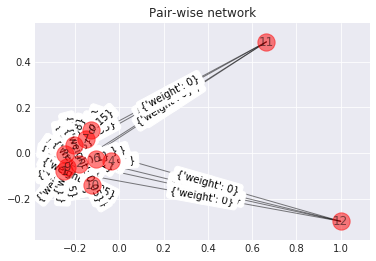

Before sorting:  {1: 0.17914795588611876, 2: 0.21731630681987024, 3: 0.2553608632528783, 4: 0.01456310682783736, 5: 0.2316700194184336, 6: 0.01456310682783736, 7: 0.01456310682783736, 8: 0.01456310682783736, 9: 0.01456310682783736, 10: 0.01456310682783736, 11: 0.01456310682783736, 12: 0.01456310682783736}


[(4, 0.01456310682783736),
 (6, 0.01456310682783736),
 (7, 0.01456310682783736),
 (8, 0.01456310682783736),
 (9, 0.01456310682783736),
 (10, 0.01456310682783736),
 (11, 0.01456310682783736),
 (12, 0.01456310682783736),
 (1, 0.17914795588611876),
 (2, 0.21731630681987024),
 (5, 0.2316700194184336),
 (3, 0.2553608632528783)]

In [17]:
DG = nx.DiGraph()
DG.add_weighted_edges_from(edges)

# Forcing a layout 
pos = nx.spring_layout(DG)

# Make a label dictionary: {} for labeling of graph 
new_labels = dict(map(lambda x: ((x[0],x[1]), x[2]['weight']), DG.edges(data=True)))

nx.draw_networkx(DG, pos=pos,alpha=0.5)
nx.draw_networkx_edge_labels(DG, pos=pos, edge_labels=new_labels)
nx.draw_networkx_edge_labels(DG, pos=pos)
plt.title('Pair-wise network')
plt.savefig('Large-graph')
plt.show()

dicto = nx.pagerank(DG)

print("Before sorting: ", dicto) 
dicto = sorted(dicto.items(), key=lambda x: x[1])
dicto

SyntaxError: unexpected EOF while parsing (<ipython-input-9-420e87982fb6>, line 1)